In [1]:
import numpy as np
import os, sys
import galsim as gs
from galsim.angle import Angle, radians
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib import colors

tk_path = '/Users/sweveret/repos/kl-tools/kl_tools'
sys.path.insert(0, tk_path)
from velocity import VelocityMap
import transformation as transform
import likelihood, cube, priors, utils, basis

%matplotlib inline

In [2]:
true_pars = {
    'g1': 0.05,
    'g2': -0.025,
    'theta_int': np.pi / 3,
    'sini': 0.8,
    'v0': 10.,
    'vcirc': 200,
    'rscale': 5,
}

# Old version, before beta scaling
# alt_pars = {
#     'g1': 0.4781,
#     'g2': -0.7357,
#     'theta_int': 1.0699,
#     'sini': 0.9991,
#     'v0': 10.0008,
#     'vcirc': 161.1112,
#     'rscale': 8.9986,
#     }

alt_pars = {
    'g1': 0.0191,
    'g2': 0.0226,
    'theta_int': 1.0498,
    'sini': 0.7001,
    'v0': 10.1252,
    'vcirc': 221.8050,
    'rscale': 4.5674,
}

pars = {
    'Nx': 30,
    'Ny': 30,
    'flux': 10,
    'hlr': 5,
    'aspect_ratio': 0.2,
}

units = {
    'v_unit': u.Unit('km/s'),
    'r_unit': u.Unit('pix')
}

# additional args needed for prior / likelihood evaluation
halpha = 656.28 # nm
R = 5000.
z = 0.3
pars = {
    'Nx': 30, # pixels
    'Ny': 30, # pixels
    'pix_scale': 1., # arcsec / pixel
    'true_flux': 1e5, # counts
    'true_hlr': 5, # pixels
    'v_unit': u.Unit('km / s'),
    'r_unit': u.Unit('kpc'),
    'z': z,
    'spec_resolution': R,
    # 'line_std': 0.17,
    'line_std': halpha * (1.+z) / R, # emission line SED std; nm
    'line_value': 656.28, # emission line SED std; nm
    'line_unit': u.Unit('nm'),
    'sed_start': 655,
    'sed_end': 657.5,
    'sed_resolution': 0.025,
    'sed_unit': u.Unit('nm'),
    'cov_sigma': 3, # pixel counts; dummy value
    'bandpass_throughput': '.2',
    'bandpass_unit': 'nm',
    'bandpass_zp': 30,
    'priors': {
        'g1': priors.GaussPrior(0., 0.3),#, clip_sigmas=2),
        'g2': priors.GaussPrior(0., 0.3),#, clip_sigmas=2),
        'theta_int': priors.UniformPrior(0., np.pi),
        'sini': priors.UniformPrior(0., 1.),
        'v0': priors.UniformPrior(0, 20),
        'vcirc': priors.GaussPrior(200, 10, zero_boundary='positive'),# clip_sigmas=2),
        'rscale': priors.UniformPrior(0, 10),
    },
    'intensity': {
        # For this test, use truth info
        # 'type': 'inclined_exp',
        # 'flux': 1e5, # counts
        # 'hlr': 5, # pixels
        'type': 'basis',
        'basis_type': 'shapelets',
        'basis_kwargs': {
            'Nmax': 12,
            'plane': 'disk'
            }
    },
    # 'marginalize_intensity': True,
    # 'psf': gs.Gaussian(fwhm=3), # fwhm in pixels
    'use_numba': False,
}

In [3]:
# make datavector
li, le, dl = 655.8, 656.8, 0.1
lambdas = [(l, l+dl) for l in np.arange(li, le, dl)]

bandpasses = cube.setup_simple_bandpasses(
    li, le, dl,
    throughput=pars['bandpass_throughput'],
    zp=pars['bandpass_zp'],
    unit=pars['bandpass_unit']
    )

Nx, Ny = 30, 30
Nspec = len(lambdas)
shape = (Nx, Ny, Nspec)
print('Setting up test datacube and true Halpha image')
datacube, sed, vmap, true_im = likelihood.setup_likelihood_test(
    true_pars, pars, shape, lambdas
    )

Setting up test datacube and true Halpha image


## Double check that vmaps are ~the same

/var/folders/92/vynp_rhj5v555c18dmsmnrpc0000gq/T/ipykernel_9218/1480843331.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, vmap_true, cmap='RdBu')
/var/folders/92/vynp_rhj5v555c18dmsmnrpc0000gq/T/ipykernel_9218/1480843331.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, vmap_alt, cmap='RdBu')
/var/folders/92/vynp_rhj5v555c18dmsmnrpc0000gq/T/ipykernel_9218/1480843331.py:27: MatplotlibDeprecationWarning: shadi

Text(0.5, 0.98, 'Velocity Map comparison')

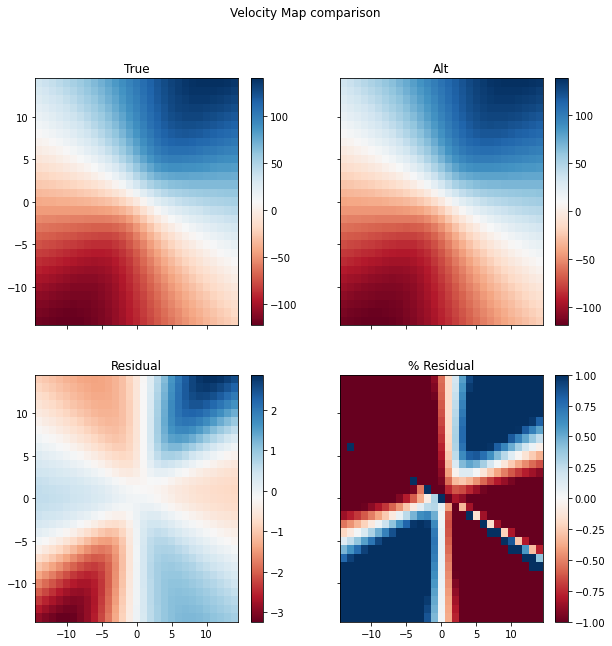

In [4]:
Nx, Ny = pars['Nx'], pars['Ny']
X, Y = utils.build_map_grid(Nx, Ny)

vmap_true_pars = {**true_pars, **units}
VMap_true = VelocityMap('default', vmap_true_pars)

vmap_alt_pars = {**alt_pars, **units}
VMap_alt = VelocityMap('default', vmap_alt_pars)

vmap_true = VMap_true('obs', X, Y)
vmap_alt  = VMap_alt('obs', X, Y)

plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10))

plt.subplot(221)
plt.pcolormesh(X, Y, vmap_true, cmap='RdBu')
plt.title('True')
plt.colorbar()

plt.subplot(222)
plt.pcolormesh(X, Y, vmap_alt, cmap='RdBu')
plt.title('Alt')
plt.colorbar()

plt.subplot(223)
resid = vmap_true-vmap_alt
plt.pcolormesh(X, Y, resid, cmap='RdBu')
plt.title('Residual')
plt.colorbar()

plt.subplot(224)
plt.pcolormesh(X, Y, 100.*resid/vmap_true, cmap='RdBu',
               vmin=-1, vmax=1)
plt.title('% Residual')
plt.colorbar()

plt.suptitle('Velocity Map comparison')

## Now check that the intensity maps are the same (using basis)

In [5]:
def make_exp_imap(theta_pars, flux, hlr, nx, ny, aspect_ratio, n=1):
    
    pars = theta_pars
    
    trunc = 4*hlr
    
    inc = Angle(np.arcsin(pars['sini']), radians)

    gal = gs.InclinedSersic(n=n, inclination=inc, half_light_radius=hlr,
                            scale_h_over_r=aspect_ratio, flux=flux, trunc=trunc)
    
    rot_angle = Angle(pars['theta_int'], radians)
    gal = gal.rotate(rot_angle)
    
    g1, g2 = pars['g1'], pars['g2']
    gal = gal.shear(g1=g1, g2=g2)
    
    image = gal.drawImage(nx=nx, ny=ny, scale=1)
    
    print(f'scale={image.scale}')
    
    imap = image.array
    
    return imap

def make_basis_imap(theta_pars, pars, datacube):
    imap = likelihood._setup_imap(theta_pars, datacube, pars)
    i = imap.render(theta_pars, datacube, pars)
    marg = imap.fitter.compute_marginalization_det(pars=pars, log=True)
    mle = imap.fitter.mle_coefficients
    
    return i, marg, mle

def make_basis_imap2(theta_pars, datacube, pars, nx, ny, plane=None, nmax=None):
    
    imap = np.zeros((nx, ny))
    
    data = datacube.stack().reshape(nx*ny)
    
    X, Y = utils.build_map_grid(nx, ny)
    
    if plane is None:
        plane = pars['intensity']['basis_kwargs']['plane']

    print(plane)
    Xp, Yp = transform.transform_coords(X, Y, 'obs', plane, theta_pars)
    if plane == 'obs':
        assert (X==Xp).all()
        assert (Y==Yp).all()
    
    if nmax is None:
        nmax = pars['intensity']['basis_kwargs']['Nmax']
        
    shapelets = basis.ShapeletBasis(Nx, Ny, pars['pix_scale'], plane, Nmax=nmax)
    print(shapelets.N)
    
    design_matrix = np.zeros((Nx*Ny, shapelets.N))
    for n in range(shapelets.N):
        func, args = shapelets._get_basis_func(n)
        x, y = Xp.reshape(nx*ny), Yp.reshape(nx*ny)
        design_matrix[:,n] = func(x, y, *args)
        
    coeff = np.linalg.pinv(design_matrix).dot(data)
    
    for n in range(shapelets.N):
        func, args = shapelets._get_basis_func(n)
        imap += coeff[n]*func(Xp, Yp, *args)
        
    # Now compute marginalization factor
    sig = pars['cov_sigma']
    M = (1./sig**2) * design_matrix.T.dot(design_matrix)
    marg = np.linalg.slogdet(M)
    
    return imap, marg, coeff

disk
1
disk
1


/var/folders/92/vynp_rhj5v555c18dmsmnrpc0000gq/T/ipykernel_9218/3357466124.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, np.sum(datacube._data, axis=2))
/var/folders/92/vynp_rhj5v555c18dmsmnrpc0000gq/T/ipykernel_9218/3357466124.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, imap_true)
/var/folders/92/vynp_rhj5v555c18dmsmnrpc0000gq/T/ipykernel_9218/3357466124.py:13: MatplotlibDeprecationWarning: shading='f

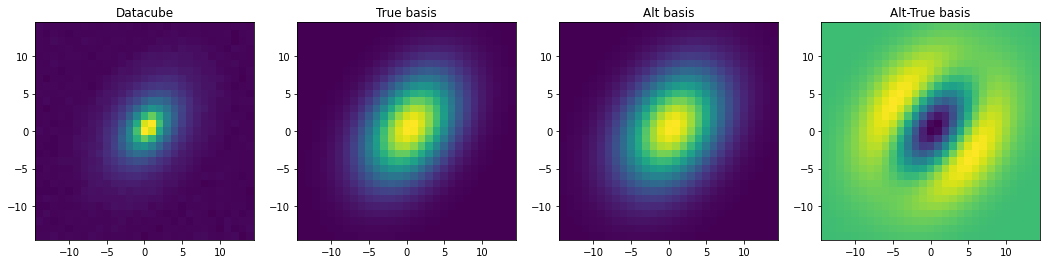

In [6]:
nmax = 0
plane = 'disk'
imap_true, marg_true, mle_true = make_basis_imap2(true_pars, datacube, pars, Nx, Ny, plane=plane, nmax=nmax)
imap_alt, marg_alt, mle_alt  = make_basis_imap2(alt_pars, datacube, pars, Nx, Ny, plane=plane, nmax=nmax)

plt.subplot(141)
plt.pcolormesh(X, Y, np.sum(datacube._data, axis=2))
plt.title('Datacube')
plt.subplot(142)
plt.pcolormesh(X, Y, imap_true)
plt.title('True basis')
plt.subplot(143)
plt.pcolormesh(X, Y, imap_alt)
plt.title('Alt basis')
plt.subplot(144)
plt.pcolormesh(X, Y, imap_alt-imap_true)
plt.title('Alt-True basis')
plt.gcf().set_size_inches(18,4)

/var/folders/92/vynp_rhj5v555c18dmsmnrpc0000gq/T/ipykernel_9218/586242396.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, true, cmap='gray')
/var/folders/92/vynp_rhj5v555c18dmsmnrpc0000gq/T/ipykernel_9218/586242396.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, imap_true, cmap='gray')
/var/folders/92/vynp_rhj5v555c18dmsmnrpc0000gq/T/ipykernel_9218/586242396.py:33: MatplotlibDeprecationWarning: shading='fla

True marginalization factor: -1255.37
Alt marginalization factor: -1239.74
Alt-True marg factor: 15.63


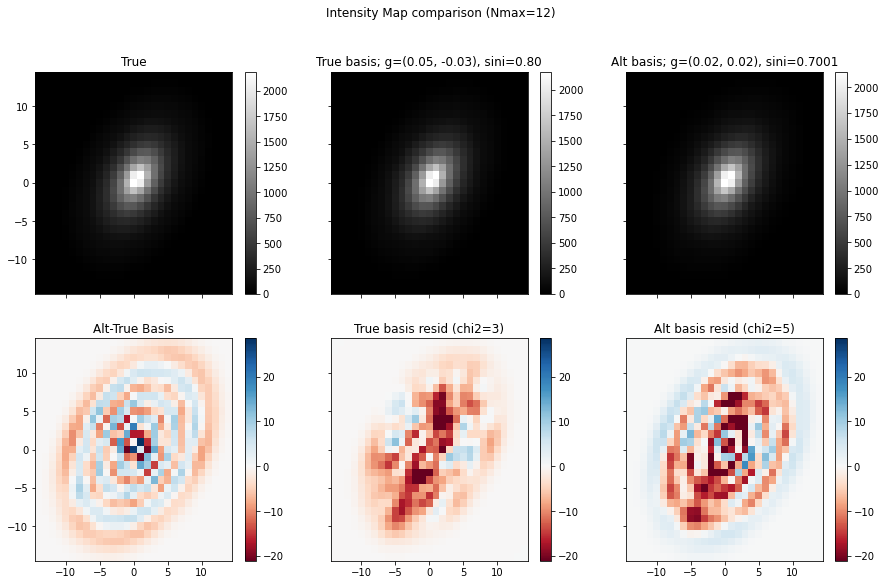

In [13]:
flux, hlr = pars['true_flux'], pars['true_hlr']
# true = make_exp_imap(true_pars, flux, hlr, Nx, Ny, 0.1)
true = true_im
# imap_alt = make_imap(alt_pars, flux, hlr, Nx, Ny, pars['aspect_ratio'])

nmax = 12

plane = 'disk'
pars['intensity']['basis_kwargs']['Nmax'] = nmax
pars['intensity']['basis_kwargs']['plane'] = plane
imap_true, marg_true, mle_true = make_basis_imap(true_pars, pars, datacube)
imap_alt, marg_alt, mle_alt  = make_basis_imap(alt_pars, pars, datacube)

cmap = 'RdBu'

divnorm = colors.TwoSlopeNorm(vcenter=0.)
plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(15,9), facecolor='w')

plt.subplot(231)
plt.pcolormesh(X, Y, true, cmap='gray')
plt.title('True')
plt.colorbar()

plt.subplot(232)
plt.pcolormesh(X, Y, imap_true, cmap='gray')
g1, g2 = true_pars['g1'], true_pars['g2']
sini = true_pars['sini']
g = f'({g1:.2f}, {g2:.2f})'
plt.title(f'True basis; g={g}, sini={sini:.2f}')
plt.colorbar()

plt.subplot(233)
plt.pcolormesh(X, Y, imap_alt, cmap='gray')
g1, g2 = alt_pars['g1'], alt_pars['g2']
sini = alt_pars['sini']
g = f'({g1:.2f}, {g2:.2f})'
plt.title(f'Alt basis; g={g}, sini={sini:.4f}')
plt.colorbar()

plt.subplot(234)
resid = imap_true-imap_alt
plt.pcolormesh(X, Y, resid, cmap=cmap, norm=divnorm)
plt.title(f'Alt-True Basis')
plt.colorbar()

plt.subplot(235)
resid = imap_true-true
sig = pars['cov_sigma']
chi2 = np.sum((resid/sig)**2) / (Nx*Ny)
plt.pcolormesh(X, Y, resid, cmap=cmap, norm=divnorm)
plt.title(f'True basis resid (chi2={chi2:.0f})')
plt.colorbar()

plt.subplot(236)
resid = imap_alt-true
chi2 = np.sum((resid/sig)**2) / (Nx*Ny)
plt.pcolormesh(X, Y, resid, cmap=cmap, norm=divnorm)
plt.title(f'Alt basis resid (chi2={chi2:.0f})')
plt.colorbar()

plt.suptitle(f'Intensity Map comparison (Nmax={nmax})')

print(f'True marginalization factor: {marg_true:.2f}')
print(f'Alt marginalization factor: {marg_alt:.2f}')
print(f'Alt-True marg factor: {marg_alt-marg_true:.2f}')

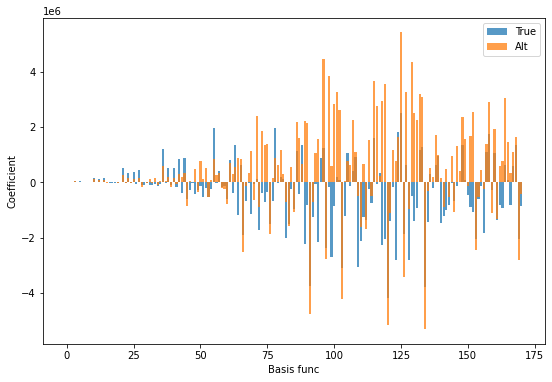

In [8]:
l = range(len(mle_true))
plt.bar(l, mle_true, alpha=0.75, label='True')
plt.bar(l, mle_alt, alpha=0.75, label='Alt')
plt.legend()
plt.xlabel('Basis func')
plt.ylabel('Coefficient')
plt.gcf().set_size_inches(9,6)

## Compute slices

In [9]:
flux, hlr = pars['flux'], pars['hlr']
flux=10

print(true_pars)
print(alt_pars)

imap1 = make_basis_imap(true_pars, datacube, pars)
imap2 = make_basis_imap2(true_pars, datacube, pars)

cmap = 'bwr'

plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10))

plt.subplot(221)
plt.pcolormesh(X, Y, imap1, cmap='gray')
plt.title('1')
plt.colorbar()

plt.subplot(222)
plt.pcolormesh(X, Y, imap2, cmap='gray')
plt.title('2')
plt.colorbar()

plt.subplot(223)
resid = imap1-imap2
plt.pcolormesh(X, Y, resid, cmap=cmap)
plt.title('Residual')
plt.colorbar()

plt.subplot(224)
plt.pcolormesh(X, Y, 100.*resid/imap1, cmap=cmap,
               vmin=-20, vmax=20)
plt.title('% Residual')
plt.colorbar()

plt.suptitle('Intensity Map comparison')

KeyError: 'flux'